In [1]:
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import pandas as pd
from pandas import DataFrame, Series

# Solving the system of differential equations
<br>Original equations: <br>
$\ \ \ \ \ \ x'' + \frac{k}{m}x - (l+x)\theta'^2 - g \cos\theta = 0$ <br>
$\ \ \ \ \ \ \theta'' + \frac{g \sin\theta + 2x'\theta'}{l+x} = 0$ <br><br>
Convert to system of 1st order: <br>
$ \qquad y_{1} = x \qquad \qquad y_{1} ' = y_{2} = x' $ <br>
$ \qquad y_{2} = x' \qquad \qquad y_{2}' = x'' = -\frac{k}{m}y_{1} + (l+y_{1})(y_{4})^2 + g \cos y_{3} $ <br>
$ \qquad y_{3} = \theta \qquad \qquad y_{3}' = y_{4} = \theta' $ <br>
$ \qquad y_{4} = \theta' \qquad \qquad y_{4}' = \theta'' = -\frac{g \sin y_{3} - 2y_{2}y_{4}}{l+y_{1}} $

In [2]:
def pend(I, t, m, k, l, g):
    dy1dt = I[1]                                                  # y1' = y2 = x'
    dy2dt = (-k/m)*I[0] + (l+I[0])*(I[3])**2 + g*math.cos(I[2])   # y2' = x"
    dy3dt = I[3]                                                  # y3' = y4 = theta' 
    dy4dt = (-g*math.sin(I[2]) - (2.0*I[1]*I[3])) / (l+I[0])      # y4' = theta" 
    return [dy1dt, dy2dt, dy3dt, dy4dt]

# Performing Monte Carlo simulation

In [10]:
# Define some arguments used
totTime = 30 # in seconds
numSteps = 6000 # number of steps for totTime (step size=0.005)
numTrials = 100000
numRuns = 10

In [8]:
# Initialize arrays and data frames
t = np.linspace(0, totTime, numSteps) # time array
angleData = DataFrame() 
angleFailureData = DataFrame()
stretchData = DataFrame()
stretchFailureData = DataFrame()
parameterData = DataFrame() 

# Run the Monte Carlo
for run in range(numRuns):
    for trial in range(numTrials):
    
        # Define parameters
        mass = norm.rvs(1.0, 0.1)             # pendulum mass (kilograms)
        spring = norm.rvs(30.0, 0.25)         # spring constant (Newtons/meter)
        length = norm.rvs(1.0, 0.1)           # unstretched pendulum length (meters)
        gravity = norm.rvs(9.8, 0.1)          # acceleration due to gravity (meters/second^2)
    
        # Define initial conditions
        initStretch = norm.rvs(0.1, 0.01)     # initial stretch (meters)
        initStretchPrime = 0                  # initial rate of change in stretch (meters/second)
        initAngle = norm.rvs(0.175, 0.01)     # initial angle of swing (radians) (about N(10, 0.6) in degrees)
        initAnglePrime = 0                    # initial rate of change in angle (radians/second)
    
        initial_conditions = [initStretch, initStretchPrime, initAngle, initAnglePrime]    

        # Calling odeint
        results = DataFrame(integrate.odeint(pend, initial_conditions, t, 
                                             args=(mass, spring, length, gravity)))    
    
        stretchSeries = Series(results[0])
        angleSeries = Series(results[2])
   
        # Define performance metric
        if (angleSeries.max() > math.radians(21)):     
            angleFailureData = pd.concat( [angleFailureData, angleSeries], axis=1 )
            angleFailureData = angleFailureData.rename( columns={ 2:'trial'+str(trial) } )
            stretchFailureData = pd.concat( [stretchFailureData, stretchSeries], axis=1 )
            stretchFailureData = stretchFailureData.rename( columns={ 0:'Trial '+str(trial) } )
            parameterData = pd.concat( [parameterData, Series( {'Mass':mass, 'Spring':spring, 
                                       'Length':length, 'Gravity':gravity, 
                                       'Initial Stretch':initStretch, 'Initial Angle':initAngle,
                                       'Class':0} ) ], axis=1 )
            parameterData = parameterData.rename( columns={ 0:'Trial '+str(trial) } )        
        
        else:
            angleData = pd.concat( [angleData, angleSeries], axis=1 ) 
            angleData = angleData.rename( columns={ 2:'Trial '+str(trial) } )    
            stretchData = pd.concat( [stretchData, stretchSeries], axis=1 )
            stretchData = stretchData.rename( columns={ 0:'Trial '+str(trial) } )
            parameterData = pd.concat( [parameterData, Series( {'Mass':mass, 'Spring':spring,
                                       'Length':length, 'Gravity':gravity,
                                       'Initial Stretch':initStretch, 'Initial Angle':initAngle,
                                       'Class':1} ) ], axis=1 )
            parameterData = parameterData.rename( columns={ 0:'Trial '+str(trial) } )

    # Move 'Class' to the end in the parameter data frame
    cols = list(parameterData.T)
    cols.insert( len(cols)-1, cols.pop(cols.index('Class')) )
    parameterData = parameterData.T.loc[:, cols]
    parameterData = parameterData.T

    # Save parameter data to file
    parameterData.to_csv('ParameterData_'+str(run)+'.csv', encoding='utf-8')

# Plot angle over time

###### Degrees

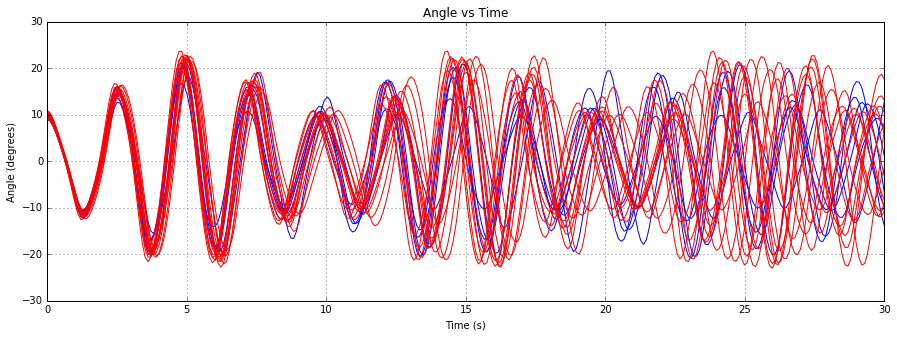

In [9]:
plt.figure( figsize=(15, 5) )
plt.title('Angle vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.grid()

# Plot successes
(rowCount, colCount) = angleData.shape
for colNum in range(colCount):
    radianAngles = angleData.iloc[:, colNum].values
    degreeAngles = [ math.degrees(x) for x in radianAngles ]
    plt.plot(t, degreeAngles, 'b') 
  
# Plot failures
(rowCount, colCount) = angleFailureData.shape  
for colNum in range(colCount):
    radianAngles = angleFailureData.iloc[:, colNum].values
    degreeAngles = [ math.degrees(x) for x in radianAngles ]
    plt.plot(t, degreeAngles, 'r')

plt.savefig('AngleDegreesPlot.png')   

###### Radians

In [ ]:
plt.figure( figsize=(15, 5) )
plt.title('Angle vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')
plt.grid()

# Plot successes
(rowCount, colCount) = angleData.shape
for colNum in range(colCount):
    plt.plot(t, angleData.iloc[:, colNum], 'b')     
  
# Plot failures
(rowCount, colCount) = angleFailureData.shape  
for colNum in range(colCount):
    plt.plot(t, angleFailureData.iloc[:, colNum], 'r')

plt.savefig('AngleRadiansPlot.png')   

# Plot stretch over time

In [ ]:
plt.figure( figsize=(15,5) )
plt.title('Stretch vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Stretch (m)')
plt.grid()

# Plot successes
(rowCount, colCount) = stretchData.shape
for colNum in range(colCount):
    col = stretchData.iloc[:, colNum]
    plt.plot(t, col, 'b')
  
# Plot failures
(rowCount, colCount) = stretchFailureData.shape  
for colNum in range(colCount):
    col = stretchFailureData.iloc[:, colNum]
    plt.plot(t, col, 'r')

plt.savefig('StretchPlot.png')